In [ ]:
import pandas as pd

# Load datasets
train_df = pd.read_csv('/content/train_set.csv')
val_df = pd.read_csv('/content/validation_set.csv')
test_df = pd.read_csv('/content/test_set.csv')
extra_train_df = pd.read_csv('/content/employee_review_mturk_dataset_v10_kaggle.csv')
extra_val_df = pd.read_csv('/content/employee_review_mturk_dataset_test_v6_kaggle.csv')

# Integrate datasets
employee_feedback_df = pd.concat([train_df, val_df, test_df, extra_train_df, extra_val_df], ignore_index=True)

# Display the combined dataset info
print(employee_feedback_df.info())

# Clean data
employee_feedback_df['label'].fillna(-1, inplace=True)  # Fill missing labels with -1
employee_feedback_df['feedback_len'].fillna(employee_feedback_df['feedback'].apply(len), inplace=True)  # Calculate feedback length if missing
employee_feedback_df['num_of_sent'].fillna(employee_feedback_df['feedback'].apply(lambda x: len(x.split('.'))), inplace=True)  # Calculate number of sentences if missing
employee_feedback_df['performance_class'].fillna(employee_feedback_df['performance_class'].mode()[0], inplace=True)  # Fill with most common performance class
employee_feedback_df['potential_class'].fillna(employee_feedback_df['potential_class'].mode()[0], inplace=True)  # Fill with most common potential class
employee_feedback_df['feedback_clean'].fillna(employee_feedback_df['feedback'], inplace=True)  # Fill with original feedback if clean feedback is missing
employee_feedback_df['data_type'].fillna('unknown', inplace=True)  # Fill with 'unknown' if data type is missing
employee_feedback_df['updated'].fillna(False, inplace=True)  # Fill missing updated values with False

# Remove duplicates based on 'id' column
employee_feedback_df.drop_duplicates(subset='id', inplace=True)

# Display summary statistics
print(employee_feedback_df.describe())

# Check for missing values again
print(employee_feedback_df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2100 non-null   int64  
 1   person_name        2100 non-null   object 
 2   nine_box_category  2100 non-null   object 
 3   feedback           2100 non-null   object 
 4   adjusted           1650 non-null   object 
 5   reviewed           2100 non-null   bool   
 6   label              997 non-null    float64
 7   feedback_len       772 non-null    float64
 8   num_of_sent        772 non-null    float64
 9   performance_class  997 non-null    float64
 10  potential_class    997 non-null    float64
 11  feedback_clean     997 non-null    object 
 12  data_type          772 non-null    object 
 13  updated            450 non-null    object 
dtypes: bool(1), float64(5), int64(1), object(7)
memory usage: 215.5+ KB
None
                 id        label  feedback_len 

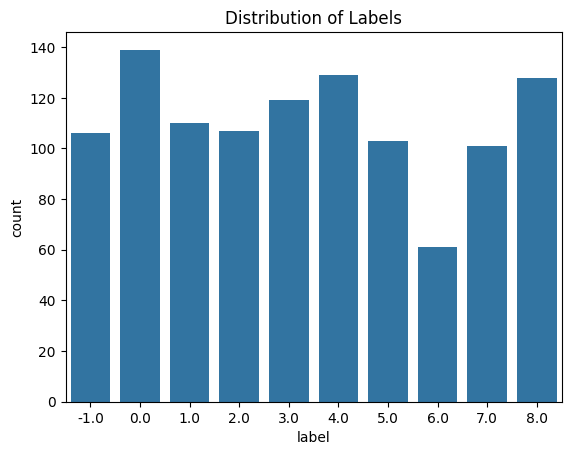

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of ratings (if available)
if 'label' in employee_feedback_df.columns:
    sns.countplot(x='label', data=employee_feedback_df)
    plt.title('Distribution of Labels')
    plt.show()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


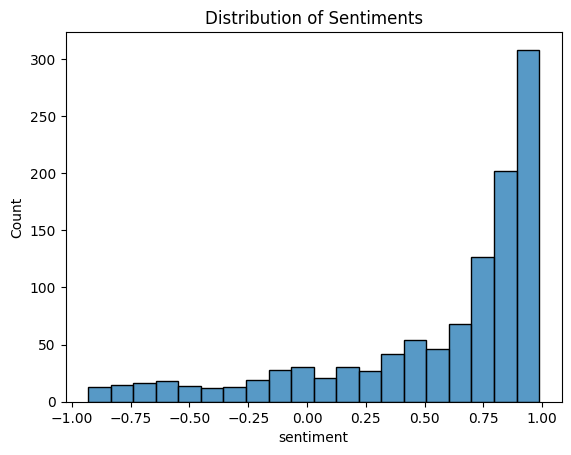

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Initialize the sentiment analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment
def calculate_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Apply sentiment analysis
employee_feedback_df['sentiment'] = employee_feedback_df['feedback'].apply(calculate_sentiment)

# Distribution of sentiments
sns.histplot(employee_feedback_df['sentiment'], bins=20)
plt.title('Distribution of Sentiments')
plt.show()

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

employee_feedback_df['processed_text'] = employee_feedback_df['feedback'].apply(preprocess_text)

# Vectorize the text
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(employee_feedback_df['processed_text'])

# Perform LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Display the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, tfidf_vectorizer.get_feature_names_out(), 10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Topic 0:
work team tasks time performance good potential often would well
Topic 1:
work team company time tasks improve good job shows great
Topic 2:
work time worker good potential one great performance well team
Topic 3:
work improve potential performance worker good company time quality great
Topic 4:
work always team needs time great well see potential much


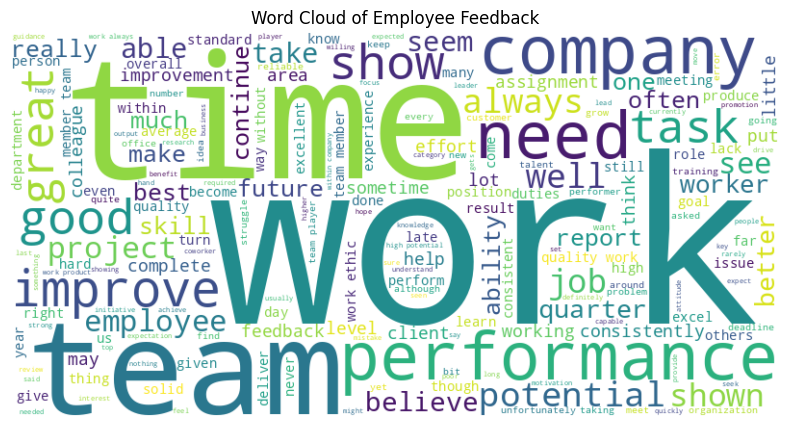

In [ ]:
# Word Cloud
all_text = ' '.join(employee_feedback_df['processed_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Employee Feedback')
plt.show()